In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## TODO: Remove later
_Code Refs_
https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/lite/python/tflite_convert.py#L104
`converter_fn = lite.TFLiteConverter.from_keras_model_file
converter_kwargs["model_file"] = flags.keras_model_file`

Actual code in:
https://www.gitmemory.com/gargn
'''
model = tf.saved_model.load(export_dir)
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 28, 28])
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()
open("/tmp/mnist_fashion/converted_model.tflite", "wb").write(tflite_model)
'''
Note that the model has been saved with tf.saved_model, and not with keras convience function.

    

In [2]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [4]:
######## GPU HACK FOR RTX 2070 ###########
## Please ignore if not training on GPU ##
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True  # dont allocate all memory at once
config.gpu_options.allocator_type = 'BFC'  #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc
config.gpu_options.per_process_gpu_memory_fraction = 2.0  # Use host memory as swap space
session = InteractiveSession(config=config)
K.set_session(session)
##########################################

In [5]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

In [6]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")

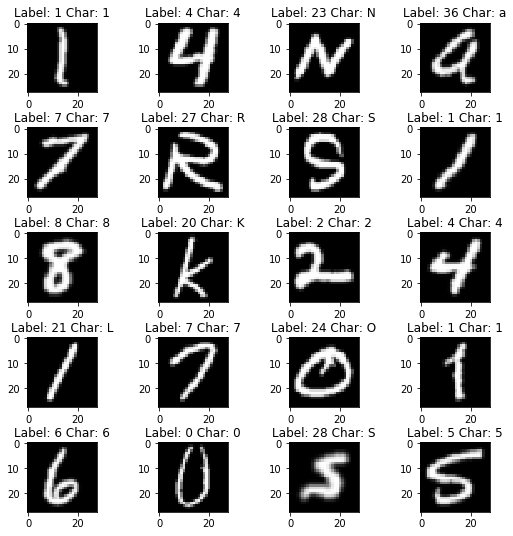

In [7]:
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(test['features'], test['labels'], mappings)

In [9]:
# Normalize the data
norm_train_features = keras.utils.normalize(train['features'])
norm_test_features = keras.utils.normalize(test['features'])

# one hot encode training labels
one_hot_train_labels = tf.one_hot(train['labels'], 47)
one_hot_test_labels = tf.one_hot(test['labels'], 47)

## Our first Convolutional Neural Network

In [10]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

# (3) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (4) Dimensions after pooling are 13x13x64. The 28x28 image is now 13x13 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_1')
cnn.summary()

Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2769152   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               

In [11]:
# Lets compile the model and train it
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = cnn.fit(norm_train_features, one_hot_train_labels, epochs=10, batch_size=128)

Epoch 1/10
697932/697932 [==============================] - 33s 48us/sample - loss: 0.4692 - accuracy: 0.8421
Epoch 2/10
697932/697932 [==============================] - 30s 43us/sample - loss: 0.3198 - accuracy: 0.8846
Epoch 3/10
697932/697932 [==============================] - 30s 44us/sample - loss: 0.2893 - accuracy: 0.8937
Epoch 4/10
697932/697932 [==============================] - 30s 43us/sample - loss: 0.2699 - accuracy: 0.8987
Epoch 5/10
697932/697932 [==============================] - 30s 43us/sample - loss: 0.2537 - accuracy: 0.9035
Epoch 6/10
697932/697932 [==============================] - 30s 43us/sample - loss: 0.2415 - accuracy: 0.9068
Epoch 7/10
697932/697932 [==============================] - 30s 43us/sample - loss: 0.2304 - accuracy: 0.9102
Epoch 8/10
697932/697932 [==============================] - 30s 43us/sample - loss: 0.2213 - accuracy: 0.9127
Epoch 9/10
697932/697932 [==============================] - 30s 44us/sample - loss: 0.2128 - accuracy: 0.9154
Epoch 10/1

In [13]:
# Evaluate the model on the test set
cnn.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 5s 47us/sample - loss: 0.3395 - accuracy: 0.8888


[0.3395466546198428, 0.8887752]

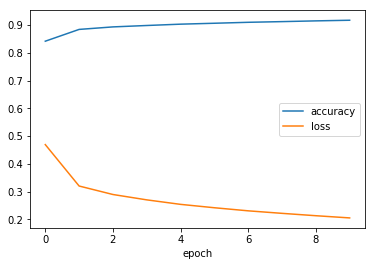

In [14]:
# Visualize the training
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'], loc='right')
plt.xlabel('epoch')
plt.show()

Confusion Matrix
[[4105    1    2 ...    2    2    1]
 [   0 5624    2 ...    0    8    5]
 [   0    3 5506 ...    5    3    1]
 ...
 [   0    1    1 ...  240    0    1]
 [   0    1    0 ...    0 2265   10]
 [   1    6    1 ...    0   13 2779]]


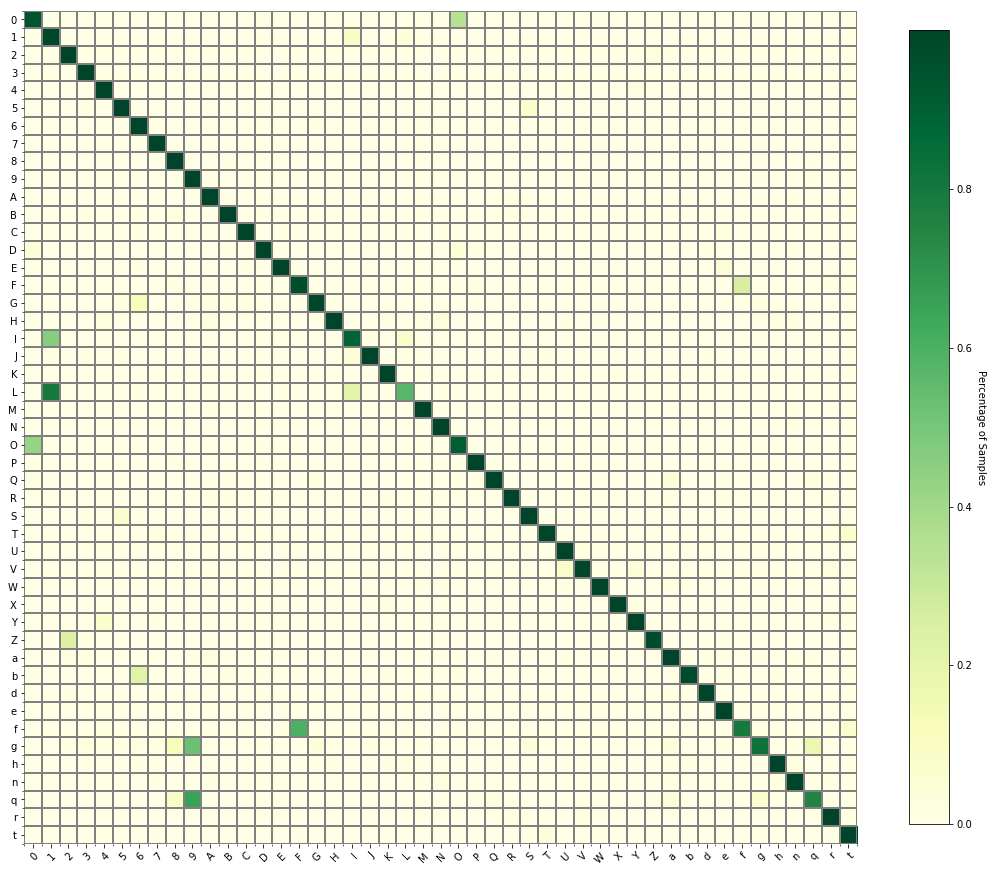

In [21]:
predictions = cnn.predict(norm_test_features)  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = emnist_utils.generate_confusion_matrix(test['labels'], y_pred)
print(confusion)
emnist_utils.plot_confusion_matrix(confusion, mappings)

In [22]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (4) Dimensions after pooling are 13x13x64. The 28x28 image is now 13x13 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2 = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_1')
cnn2.summary()

Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        

In [23]:
# Lets compile the model and train it
cnn2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = cnn2.fit(norm_train_features, one_hot_train_labels, epochs=10, batch_size=128)

Epoch 1/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.3776 - accuracy: 0.8680
Epoch 2/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.2686 - accuracy: 0.8992
Epoch 3/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.2469 - accuracy: 0.9058
Epoch 4/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.2339 - accuracy: 0.9097
Epoch 5/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.2227 - accuracy: 0.9131
Epoch 6/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.2137 - accuracy: 0.9159
Epoch 7/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.2066 - accuracy: 0.9178
Epoch 8/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.1997 - accuracy: 0.9199
Epoch 9/10
697932/697932 [==============================] - 70s 100us/sample - loss: 0.1938 - accuracy: 0.9215
E

In [24]:
# Evaluate the model on the test set
cnn2.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 8s 71us/sample - loss: 0.2898 - accuracy: 0.9033


[0.28983360167566535, 0.90326077]

Confusion Matrix
[[4354    0    2 ...    1    0    0]
 [   0 5944    4 ...    0    1    5]
 [   0    1 5508 ...    0    1    0]
 ...
 [   0    0    1 ...  222    0    0]
 [   0    1    0 ...    0 2257    5]
 [   1    2    0 ...    0    5 2805]]


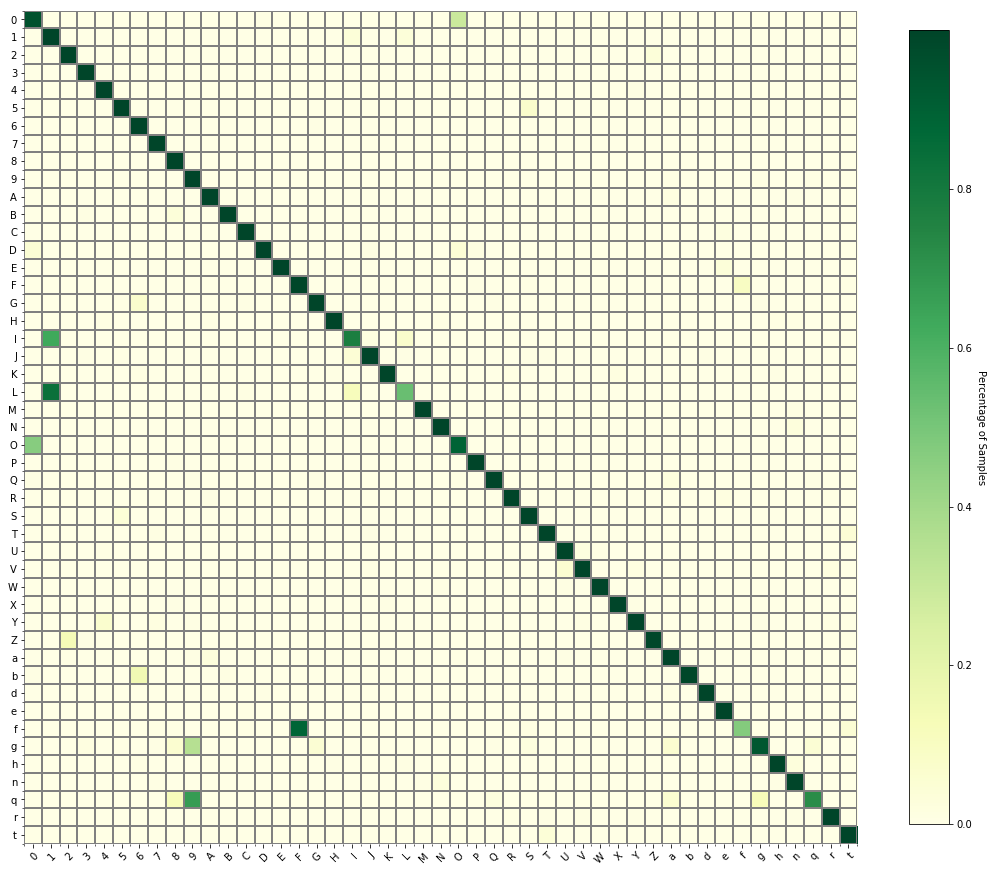

In [25]:
predictions = cnn2.predict(norm_test_features)  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = emnist_utils.generate_confusion_matrix(test['labels'], y_pred)
print(confusion)
emnist_utils.plot_confusion_matrix(confusion, mappings)